# Train-Val-Test Split

In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from PIL import Image, ImageDraw
import cv2

from pathlib import Path
import shutil
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
##
data_dir = Path('/content/drive/MyDrive/ErdosFall25/data/PolypGenV3/')
## Check if annotation files are missing for a few images
## Suggested by Betul
data_centers = ['C1', 'C2', 'C3', 'C4','C5', 'C6']
properties = ['num_images', 'with_bbox', 'num_pos','num_neg']
data_CX_info = pd.DataFrame(np.zeros(shape = (6, 4)).astype(int),
                                    index = data_centers, columns = properties)
for data_center in data_centers:
  images_dir = data_dir / ('data_' + data_center) / ('images_' + data_center)
  bbox_dir = data_dir / ('data_' + data_center) / ('bbox_' + data_center)
  images_filenames = list(images_dir.glob('*'))
  bbox_filenames = list(bbox_dir.glob('*'))

  tmp_dict = dict()
  num_neg = 0
  for i, bbox in enumerate(bbox_filenames):
    tmp_dict[bbox.stem] = i
    if bbox.stat().st_size == 1:
      num_neg += 1

  missing = []
  for image in images_filenames:
    if data_center == 'C2' or data_center == 'C3':
      filename = image.stem
    else:
      filename = image.stem + '_mask'
    if filename not in tmp_dict:
      missing.append(image)
  if data_center == 'C3': C3_missing = missing.copy()
  print(f"number of missing annotations for {data_center} : {len(missing)}")
  data_CX_info.loc[data_center, 'num_images'] = len(images_filenames)
  data_CX_info.loc[data_center, 'with_bbox'] = len(images_filenames) - len(missing)
  data_CX_info.loc[data_center, 'num_pos'] = data_CX_info.loc[data_center, 'with_bbox'] - num_neg
  data_CX_info.loc[data_center, 'num_neg'] = num_neg
data_CX_info.loc['total'] = data_CX_info.to_numpy().sum(axis = 0)
data_CX_info
# print("total num.:", data_CX_info.to_numpy().sum(axis = 0))

number of missing annotations for C1 : 0
number of missing annotations for C2 : 0
number of missing annotations for C3 : 64
number of missing annotations for C4 : 0
number of missing annotations for C5 : 0
number of missing annotations for C6 : 0


,num_images,with_bbox,num_pos,num_neg
C1,256,256,251,5
C2,301,301,269,32
C3,457,393,392,1
C4,227,227,146,81
C5,208,208,206,2
C6,88,88,83,5
total,1537,1473,1347,126


In [ ]:
### Split of data center data ###
detection_data_dir = Path('/content/drive/MyDrive/ErdosFall25/data/detection')
folders = ['train','valid','test']
properties = ['with_bbox', 'num_pos', 'num_neg', 'proportion']
current_split_info = pd.DataFrame(np.zeros(shape = (3, 4)).astype(int),
                                    index = folders, columns = properties)
for folder in folders:
  bbox_dir = detection_data_dir / folder / 'bbox'
  current_split_info.loc[folder, 'with_bbox'] = len(list(bbox_dir.glob('*')))
  for bbox in bbox_dir.iterdir():
    if bbox.stat().st_size == 1:
      current_split_info.loc[folder, 'num_neg'] += 1
    else:
      current_split_info.loc[folder, 'num_pos'] += 1
current_split_info['proportion'] = current_split_info['num_pos'] / current_split_info['with_bbox']
current_split_info

,with_bbox,num_pos,num_neg,proportion
train,1105,1013,92,0.916742
valid,139,128,11,0.920863
test,229,206,23,0.899563


In [ ]:
### Seq pos data ###
seq_pos_dir = Path('/content/drive/MyDrive/ErdosFall25/data/PolypGenV3/sequenceData/positive')
seq_neg_dir = Path('/content/drive/MyDrive/ErdosFall25/data/PolypGenV3/sequenceData/negativeOnly')

# excluding seq1 and seq 7 in seq_pos
seq_pos_list = ['seq' + str(i) for i in (list(range(2,7)) + list(range(8,24)))]

seq_pos_info = pd.DataFrame(np.zeros(shape = (len(seq_pos_list), 3)).astype(int), \
                            index = seq_pos_list, \
                            columns = ['with_bbox', 'num_pos', 'num_neg'])
for seqX in seq_pos_list:
  for file in (seq_pos_dir / seqX / ('bbox_' + seqX)).iterdir():
    if file.stat().st_size == 1:
      seq_pos_info.loc[seqX, 'num_neg'] += 1
    else:
      seq_pos_info.loc[seqX, 'num_pos'] += 1

seq_pos_info['with_bbox'] = seq_pos_info['num_pos'] + seq_pos_info['num_neg']
seq_pos_info.loc['total'] = seq_pos_info.sum(axis = 0)
seq_pos_info

,with_bbox,num_pos,num_neg
seq2,63,60,3
seq3,15,15,0
seq4,48,46,2
seq5,250,199,51
seq6,91,62,29
seq8,73,54,19
seq9,51,42,9
seq10,25,7,18
seq11,228,136,92
seq12,260,260,0


In [ ]:
# Seq neg statistic
seq_neg_list = ['seq' + str(i) + '_neg' for i in range(1,24)]
seq_neg_info = pd.DataFrame(np.zeros(shape = (len(seq_neg_list), 1)).astype(int), \
                            index = seq_neg_list, \
                            columns = ['num_neg'])
for seqX in seq_neg_list:
  seq_neg_info.loc[seqX, 'num_neg'] = len(list((seq_neg_dir / seqX).glob('*')))

seq_neg_info.loc['total'] = seq_neg_info.sum(axis = 0)
seq_neg_info

,num_neg
seq1_neg,315
seq2_neg,302
seq3_neg,40
seq4_neg,72
seq5_neg,61
seq6_neg,90
seq7_neg,207
seq8_neg,311
seq9_neg,99
seq10_neg,292


In [ ]:
train_neg = ['seq' + str(i) + '_neg' for i in range(1,10)] + ['seq16_neg', 'seq22_neg']
print(train_neg)
print(seq_neg_info.loc[train_neg].sum())

valid_neg = ['seq15_neg']
print(valid_neg)
print(seq_neg_info.loc[valid_neg].sum())

test_neg = ['seq' + str(i) + '_neg' for i in range(16,24)]
print(test_neg)
print(seq_neg_info.loc[test_neg].sum())

['seq1_neg', 'seq2_neg', 'seq3_neg', 'seq4_neg', 'seq5_neg', 'seq6_neg', 'seq7_neg', 'seq8_neg', 'seq9_neg', 'seq16_neg', 'seq22_neg']
num_neg    1720
dtype: int64
['seq15_neg']
num_neg    278
dtype: int64
['seq16_neg', 'seq17_neg', 'seq18_neg', 'seq19_neg', 'seq20_neg', 'seq21_neg', 'seq22_neg', 'seq23_neg']
num_neg    1176
dtype: int64


In [ ]:
train_pos_seq = ['seq' + str(i) for i in (list(range(2,7)) + list(range(8,14)))]
print("train_seq:",train_pos_seq)
# print(seq_pos_info.loc[train_pos_seq].sum(axis = 0))

valid_pos_seq = ['seq14'] # mostly C2
print("valid_seq:", valid_pos_seq)
# print(seq_pos_info.loc[valid_pos_seq].sum(axis = 0))

test_pos_seq = ['seq' + str(i) for i in (list(range(15,24)))]
print("test_seq:", test_pos_seq)
# print(seq_pos_info.loc[test_pos_seq].sum(axis = 0))

seq_split_info = pd.concat([seq_pos_info.loc[train_pos_seq].sum(axis = 0), \
               seq_pos_info.loc[valid_pos_seq].sum(axis = 0), \
               seq_pos_info.loc[test_pos_seq].sum(axis = 0)],axis = 1).transpose()
seq_split_info.index = ['train', 'valid', 'test']
seq_split_info

train_seq: ['seq2', 'seq3', 'seq4', 'seq5', 'seq6', 'seq8', 'seq9', 'seq10', 'seq11', 'seq12', 'seq13']
valid_seq: ['seq14']
test_seq: ['seq15', 'seq16', 'seq17', 'seq18', 'seq19', 'seq20', 'seq21', 'seq22', 'seq23']


,with_bbox,num_pos,num_neg
train,1354,1080,274
valid,249,200,49
test,548,440,108


In [ ]:
split_info = pd.DataFrame(np.zeros(shape = (3,5)), \
             index = ['train', 'valid', 'test'], \
             columns = ['single_pos', 'single_neg', 'seq_pos_pos', 'seq_pos_neg', 'seq_neg']).astype(str)
split_info_center = split_info.copy()

split_info[['single_pos','single_neg']] = current_split_info[['num_pos', 'num_neg']]
split_info[['seq_pos_pos','seq_pos_neg']] = seq_split_info[['num_pos', 'num_neg']]
split_info.loc['train', 'seq_neg'] = seq_neg_info.loc[train_neg].sum().loc['num_neg']
split_info.loc['valid', 'seq_neg'] = seq_neg_info.loc[valid_neg].sum().loc['num_neg']
split_info.loc['test', 'seq_neg'] = seq_neg_info.loc[test_neg].sum().loc['num_neg']

split_info['num_pos'] = split_info['single_pos'] + split_info['seq_pos_pos']
split_info['num_neg'] = split_info['single_neg'] + split_info['seq_pos_neg'] + split_info['seq_neg']
split_info['pct_pos'] = split_info['num_pos'] / (split_info['num_pos'] + split_info['num_neg'])
display(split_info.style.format({
        "pct_pos":"{:.3f}%"
    }).background_gradient(subset=["pct_pos"], cmap="YlGn"))

,single_pos,single_neg,seq_pos_pos,seq_pos_neg,seq_neg,num_pos,num_neg,pct_pos
train,1013,92,1080,274,1720,2093,2086,0.501%
valid,128,11,200,49,278,328,338,0.492%
test,206,23,440,108,1176,646,1307,0.331%


In [ ]:
split_info.sum(axis = 0)

,0
single_pos,1347
single_neg,126
seq_pos_pos,1720
seq_pos_neg,431
seq_neg,3174
num_pos,3067
num_neg,3731
pct_pos,1.324103


In [ ]:
1347 + 126

1473

In [ ]:
split_info_center['seq_neg'] = 'hospital'
split_info_center[['single_pos','single_neg']] = 'C1-C6'
split_info_center.loc['train', ['seq_pos_pos','seq_pos_neg']] = 'seq2-6,8-13 (C1,C2,C4,C5)'
split_info_center.loc['valid', ['seq_pos_pos','seq_pos_neg']] = 'seq14 (C2)'
split_info_center.loc['test', ['seq_pos_pos','seq_pos_neg']] = 'seq15-23 (C2, C6)'
split_info_center.loc['test', 'seq_neg'] = 'seq_neg16-23 (C6)'
split_info_center.loc['valid', 'seq_neg'] = 'seq_neg15 (hospital)'
split_info_center.loc['train', 'seq_neg'] = 'seq_neg1-9,16,22 (hospital)'
split_info_center

,single_pos,single_neg,seq_pos_pos,seq_pos_neg,seq_neg
train,C1-C6,C1-C6,"seq2-6,8-13 (C1,C2,C4,C5)","seq2-6,8-13 (C1,C2,C4,C5)","seq_neg1-9,16,22 (hospital)"
valid,C1-C6,C1-C6,seq14 (C2),seq14 (C2),seq_neg15 (hospital)
test,C1-C6,C1-C6,"seq15-23 (C2, C6)","seq15-23 (C2, C6)",seq_neg16-23 (C6)


With the information for the EDA file, for data center C6, we have
*   88 + 324 = 412 positive images
*   5 + 1284 = 1289 negative images
*  positive proportion = 412 / 1701 ~ 24\%

In [3]:
detection_data_dir = Path('/content/drive/MyDrive/ErdosFall25/data/center_stratified')
detection_data_dir.mkdir(parents=True, exist_ok=True)
# train_dir = detection_data_dir / 'train'
# train_dir.mkdir(parents=True, exist_ok=True)
# valid_dir = detection_data_dir / 'valid'
# valid_dir.mkdir(parents=True, exist_ok=True)
# test_dir = detection_data_dir / 'test'
# test_dir.mkdir(parents=True, exist_ok=True)

In [25]:
# No need to run this section copying data completed
def copy_files(file_list, train_or_val, rename = False, destination_dir = Path('/content/drive/MyDrive/ErdosFall25/data/center_stratified')):
  """Copies images and bbox to a destination directory."""

  images_destination_dir = destination_dir / data_center / 'images' / train_or_val
  images_destination_dir.mkdir(parents=True, exist_ok=True)

  bbox_destination_dir = destination_dir / data_center / 'bbox_voc' / train_or_val
  bbox_destination_dir.mkdir(parents=True, exist_ok=True)

  yolo_destination_dir = destination_dir / data_center / 'labels' / train_or_val
  yolo_destination_dir.mkdir(parents=True, exist_ok=True)

  gtr_destination_dir = destination_dir / data_center / 'gtr' / train_or_val
  gtr_destination_dir.mkdir(parents=True, exist_ok=True)

  for i, file in enumerate(file_list):
    image_id = data_center.lower() + 's' + str(i).zfill(3)
    ## bbox voc ##
    bbox_dir = data_dir / ('data_' + data_center) / ('bbox_' + data_center)
    if rename: # for suffix in the end for C1 C4 C5 C6
      bbox_source = bbox_dir / (file.stem + '_mask.txt')
    else:
      bbox_source = bbox_dir / (file.stem + '.txt')

    ## create yolo txt ##
    if bbox_source.stat().st_size == 1:
      filename = image_id + 'n' + '_' + file.stem
      yolo_destination = yolo_destination_dir / (filename + '.txt')
      yolo_destination.touch()
      shutil.copy(file, gtr_destination_dir / (filename + '.jpg'))
    else:
      img = Image.open(file)
      image_width, image_height = img.size
      bbox = pd.read_table(bbox_source, sep = ' ', header = None)
      bbox.columns = ['class_index','top_left_x', 'top_left_y', 'bottom_right_x', 'bottom_right_y']
      num_polyp = bbox.shape[0]

      # compute yolo coordinates
      bbox['class_index'] = pd.DataFrame(np.zeros((num_polyp, )))
      bbox['x_center'] = (bbox['top_left_x'] + bbox['bottom_right_x']) / (2 * image_width)
      bbox['y_center'] = (bbox['top_left_y'] + bbox['bottom_right_y']) / (2 * image_height)
      bbox['width'] = abs((bbox['bottom_right_x'] - bbox['top_left_x']) / image_width)
      bbox['height'] = abs((bbox['bottom_right_y'] - bbox['top_left_y']) / image_height)
      bbox['sizes'] = bbox['width'] * bbox['height']

      minimum_size = bbox['sizes'].min()
      per_string = f"{100 * minimum_size:.2f}"
      if len(per_string) > 4:
        per_string = per_string[:4]
      else:
        per_string = per_string.zfill(4)
      per_string = per_string.replace('.','d')

      filename = image_id + 'p' + str(num_polyp) + '_' + per_string + '_' + file.stem
      # print(per_string, filename)
      yolo_destination = yolo_destination_dir / (filename + '.txt')

      yolo_array = bbox[['class_index', 'x_center', 'y_center', 'width', 'height']].to_numpy()
      np.savetxt(yolo_destination, yolo_array, fmt='%d %.6f %.6f %.6f %.6f', delimiter=' ')

      draw = ImageDraw.Draw(img)
      for polpy in range(num_polyp):
          rectangle_coords = [(bbox['top_left_x'][polpy], bbox['top_left_y'][polpy]), (bbox['bottom_right_x'][polpy], bbox['bottom_right_y'][polpy])]
          draw.rectangle(rectangle_coords, outline="red", width=3)
      img.save(gtr_destination_dir / (filename + '.jpg'))

    ## copy images bbox voc ##
    shutil.copy(file, images_destination_dir / (filename + '.jpg'))
    shutil.copy(bbox_source, bbox_destination_dir / (filename + '.txt'))

for data_center in ['C2', 'C3', 'C4', 'C5', 'C6']:
  images_dir = data_dir / ('data_' + data_center) / ('images_' + data_center)
  bbox_dir = data_dir / ('data_' + data_center) / ('bbox_' + data_center)
  images_filenames = sorted(list(images_dir.glob('*')))

  if data_center == 'C3':
    # drop missing data for data center C3
    C3_missing = set(C3_missing)
    images_filenames = [image for image in images_filenames if image not in C3_missing]

  # 0.8 for training set, 0.2 for test set and validation set
  images_train, images_val_test = train_test_split(images_filenames, test_size=0.2, random_state=42)
  images_val, images_test = train_test_split(images_val_test, test_size=0.5, random_state=42)

  rename = True
  if data_center == 'C2' or data_center == 'C3':
    rename = False

  if data_center == 'C6':
    # All images in 'C6' are assigned to the test set
    # print(f'copying all C6 images to test folder with rename {rename}')
    # copy_files(images_filenames, test_dir, rename)
    pass
  else:
    print(f'copying {data_center} training data with rename {rename}')
    copy_files(images_train, 'train', rename)
    print(f'copying {data_center} validation data')
    copy_files(images_val, 'val', rename)
    # print(f'copying {data_center} test data')
    # copy_files(images_test, test_dir,rename)

copying C2 training data with rename False
copying C2 validation data
copying C3 training data with rename False
copying C3 validation data
copying C4 training data with rename True
copying C4 validation data
copying C5 training data with rename True
copying C5 validation data


In [27]:
## Check the correctness of spliting
def check_split(train_or_val):
  for data_center in ['C1', 'C2', 'C3', 'C4','C5']:
    images_destination_dir = Path('/content/drive/MyDrive/ErdosFall25/data/center_stratified') / data_center / 'images' / train_or_val
    yolo_destination_dir = Path('/content/drive/MyDrive/ErdosFall25/data/center_stratified') / data_center / 'labels' / train_or_val

    images_filenames = list(images_destination_dir.glob('*'))
    for item in images_filenames:
      if not (yolo_destination_dir / (item.stem + '.txt')).exists():
          raise FileNotFoundError(f"{yolo_destination_dir / (item.stem + '.txt')} does not exist")
    print(f"{data_center} {train_or_val} checked, num images {len(images_filenames)}")
check_split('train')
check_split('val')

C1 train checked, num images 204
C2 train checked, num images 240
C3 train checked, num images 314
C4 train checked, num images 181
C5 train checked, num images 166
C1 val checked, num images 26
C2 val checked, num images 30
C3 val checked, num images 39
C4 val checked, num images 23
C5 val checked, num images 21


In [ ]:
# count number of images in each folder
print('number of images in each folder:')
print('train images:', len(list((train_dir / 'images').glob('*'))))
print('train bbox:', len(list((train_dir / 'bbox').glob('*'))))
print('valid images:', len(list((valid_dir / 'images').glob('*'))))
print('valid bbox:', len(list((valid_dir / 'bbox').glob('*'))))
print('test images:', len(list((test_dir / 'images').glob('*'))))
print('test bbox:', len(list((test_dir / 'bbox').glob('*'))))

number of images in each folder:
train images: 4169
train bbox: 1105
valid images: 666
valid bbox: 139
test images: 2231
test bbox: 229


In [ ]:
# statistics of current split
folders = ['train','valid','test']
properties = ['with_bbox', 'num_pos', 'num_neg', 'proportion']
current_split_info = pd.DataFrame(np.zeros(shape = (3, 4)).astype(int),
                                    index = folders, columns = properties)
for folder in folders:
  bbox_dir = detection_data_dir / folder / 'bbox'
  current_split_info.loc[folder, 'with_bbox'] = len(list(bbox_dir.glob('*')))
  for bbox in bbox_dir.iterdir():
    if bbox.stat().st_size == 1:
      current_split_info.loc[folder, 'num_neg'] += 1
    else:
      current_split_info.loc[folder, 'num_pos'] += 1
current_split_info['proportion'] = current_split_info['num_pos'] / current_split_info['with_bbox']
current_split_info

,with_bbox,num_pos,num_neg,proportion
train,1105,1013,92,0.916742
valid,139,128,11,0.920863
test,229,206,23,0.899563


In [ ]:
# delete seq 7
seq_info = pd.DataFrame(np.array(
[[3597 - 255, 1070 - 48, 2527 - 207, 0.297],
[944, 316, 628, 0.335],
[1608,324,1284,0.201]]
), index = folders, columns = properties)
seq_info

,with_bbox,num_pos,num_neg,proportion
train,3342.0,1022.0,2320.0,0.297
valid,944.0,316.0,628.0,0.335
test,1608.0,324.0,1284.0,0.201


In [ ]:
total_info = current_split_info.to_numpy() + seq_info.to_numpy()
total_info = pd.DataFrame(total_info, index = folders, columns = properties)
total_info['proportion'] = total_info['num_pos'] / total_info['with_bbox']
print(total_info)
summary = total_info.sum(axis = 0)
print(summary.iloc[:-1])
print(f'Overall pos proportion:{summary.loc['num_pos'] / summary.loc['with_bbox']}')

       with_bbox  num_pos  num_neg  proportion
train     4447.0   2035.0   2412.0    0.457612
valid     1083.0    444.0    639.0    0.409972
test      1837.0    530.0   1307.0    0.288514
with_bbox    7367.0
num_pos      3009.0
num_neg      4358.0
dtype: float64
Overall pos proportion:0.4084430568752545


In [ ]:
## Suppose we move seq 2 (60, 3), seq 3 (15,0), seq 4 (46,2) and seq 12 (250,0) to test set
proposal = total_info.copy()
proposal.loc['train', 'with_bbox']-= 376
proposal.loc['train', 'num_pos']-= 371
proposal.loc['train', 'num_neg']-= 5

proposal.loc['test', 'with_bbox']+= 376
proposal.loc['test', 'num_pos']+= 371
proposal.loc['test', 'num_neg']+= 5

proposal['proportion'] = proposal['num_pos'] / proposal['with_bbox']
proposal

,with_bbox,num_pos,num_neg,proportion
train,4071.0,1664.0,2407.0,0.408745
valid,1083.0,444.0,639.0,0.409972
test,2213.0,901.0,1312.0,0.407140


Adding the sequencing data, we have

In [ ]:
# With EDA info from Betul
add_seq_info = current_split_info.copy()
add_seq_info.loc['total'] = add_seq_info.sum()
add_seq_info

,with_bbox,num_pos,num_neg,proportion
train,1105.0,1013.0,92.0,0.916742
valid,139.0,128.0,11.0,0.920863
test,229.0,206.0,23.0,0.899563
total,1473.0,1347.0,126.0,2.737169


(1920, 1080) /content/drive/MyDrive/ErdosFall25/data/detection/train/images/single__9_endocv2021_positive_1006.jpg


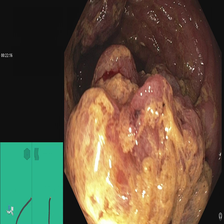

In [ ]:
train_images = list((train_dir / 'images').glob('*'))
# display the first image
img = Image.open(train_images[0])
print(img.size, train_images[0])
display(img.resize((224, 224), Image.Resampling.LANCZOS))

In [ ]:
bbox = pd.read_table(train_dir / 'bbox' / (train_images[0].stem + '.txt'), sep = ' ', header = None)
bbox.columns = ['class_index','top_left_x', 'top_left_y', 'bottom_right_x', 'bottom_right_y']
print(bbox)

rectangle_coords = [(bbox['top_left_x'][0], bbox['top_left_y'][0]), (bbox['bottom_right_x'][0], bbox['bottom_right_y'][0])]
print(rectangle_coords)
draw = ImageDraw.Draw(img)
draw.rectangle(rectangle_coords, outline="blue", width=3)
display(img.resize((224, 224), Image.Resampling.LANCZOS))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ErdosFall25/data/detection/train/bbox/single__9_endocv2021_positive_1006.txt'

In [ ]:
# multiple bbox
img = Image.open(train_dir / 'images'/ '155OLCV1_100H0010.jpg')
bbox = pd.read_table(train_dir / 'bbox' / '155OLCV1_100H0010.txt', sep = ' ', header = None)
bbox.columns = ['class_index','top_left_x', 'top_left_y', 'bottom_right_x', 'bottom_right_y']

num_polyp = bbox.shape[0]
draw = ImageDraw.Draw(img)
for polpy in range(num_polyp):
  rectangle_coords = [(bbox['top_left_x'][polpy], bbox['top_left_y'][polpy]), (bbox['bottom_right_x'][polpy], bbox['bottom_right_y'][polpy])]
  draw.rectangle(rectangle_coords, outline="blue", width=3)
display(img.resize((224, 224), Image.Resampling.LANCZOS))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ErdosFall25/data/detection/train/images/155OLCV1_100H0010.jpg'